In [1]:
import pandas as pd
import os

In [2]:
import random
import matplotlib.pyplot as plt
import collections
import numpy as np
import operator
import simpleclock

In [3]:
resources_path = os.path.join(os.path.dirname(os.path.abspath('')), "resources")
data_path = os.path.join(resources_path, "data_cine.csv")
cleaned_data_path = os.path.join(resources_path, "data_cine_cleaned.csv")

In [4]:
df_all = pd.read_csv(data_path)

In [5]:
print(df_all.shape)
print(df_all.columns.values)

(79958, 4)
['id' 'titre' 'note' 'critique']


## preprocessing

In [6]:
# remove 'empty' reviews (those sending to another website) // to be removed from the DS
def is_review_empty(s): 
    _s = s.lower().replace("  ", " ")
    return len(_s.split()) < 16 and any(sub in _s for sub in 
                                        ("voir la critique", 
                                         "voir le site", 
                                         "voir sur le site", 
                                         "voir le magazine",
                                         "voir le point",
                                         "express.fr",
                                         "point.fr",
                                         "studio ciné live",
                                         "www.",
                                        ))


df_ = df_all.loc[~df_all["critique"].apply(is_review_empty)]
df_removed = df_all.loc[df_all["critique"].apply(is_review_empty)]
empty_reviews = collections.Counter(df_removed["critique"].values)
print(f"{df_removed.shape[0]} ({df_removed.shape[0] / df_all.shape[0]:.2f}%) lines removed")

df_.loc[:, "critique"] = df_["critique"].str.strip()

df_clean = df_

# empty_reviews  # to check

6372 (0.08%) lines removed


/home/cuicui/sources/nn-training/venv/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
collections.Counter(map(len, map(str.split, map(str.lower, empty_reviews))))
# sorted(set(map(str.lower, empty_reviews)), key=lambda s: len(s.split()), reverse=True)

Counter({6: 37,
         5: 52,
         4: 30,
         10: 9,
         8: 23,
         12: 3,
         7: 22,
         1: 5,
         9: 14,
         3: 7,
         2: 12})

In [8]:
df = df_clean

In [9]:
df.to_csv(cleaned_data_path, index=False)

## exploration

In [10]:
f"{df.shape[0]} critiques pour {len(set(df.id))} films ({df.shape[0] / len(set(df.id)):.1f} en moy.)"

'73586 critiques pour 4597 films (16.0 en moy.)'

In [11]:
for idx, row in df.iloc[random.sample(range(df.shape[0]), 5), :].iterrows():  # or: ... in df.sample(5).iterrows()
    print(row.titre, ":", row.note)
    print(row.critique)
    print()

96 Heures : 4.0
Malicieusement, ces "96 heures" durent 96 minutes, mais sachez que ce duel cinématographique intense ne vous laissera pas le temps de compter les secondes.

La Merditude des Choses : 4.0
L'humour ravageur, le réalisme saisissant des situations mais aussi l'interprétation décomplexée des comédiens font de cette comédie dramatique belge une expérience surréaliste et attachante.

Total Recall Mémoires Programmées : 3.0
Les geeks hypermnésiques et autres adeptes des mises en abyme à tiroirs s'amuseront à démêler ce qui, de la nouvelle originale de Philip K. Dick et de sa première adaptation par Paul Verhoeven en 1990, a ici été sauvegardé. Les autres se lasseront rapidement des effets de manche du réalisateur (...).

Qu'un sang impur... : 3.0
Ce film qui évoque sans manichéisme les violences des deux camps en Algérie, en 1960, regarde avec finesse la manière dont chaque membre d’un commando multiethnique se bricole une morale.

Là-haut : 5.0
Dans "Là- Haut", rien n'est conf

Text(0.5, 1.0, 'nb of words per review')

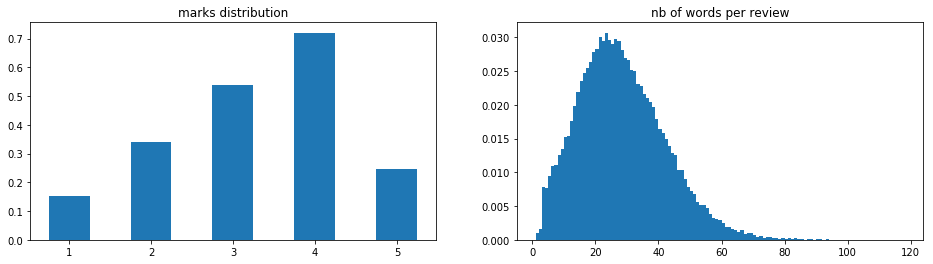

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].hist(df.note.values, density=True, bins=list(np.arange(1, 6, .5)), align="left")
axs[0].set_title("marks distribution")

lens = df.critique.apply(lambda s: len(s.split()))
axs[1].hist(lens, density=True, bins=range(min(lens), max(lens) + 1))
axs[1].set_title("nb of words per review")

In [13]:
for t in df.loc[df.critique.str.contains("(...)", regex=False)].sample(5).itertuples():
    print(t.note)
    print(t.critique)
    print()

4.0
C'est (...) le film le plus humain, à la fois le plus léger et le plus grave, le plus amusant et le plus inquiétant de Kubrick, celui où il ne pratique aucune surenchère vis-à-vis d'un genre particulier (...)

3.0
Les Seigneurs de Dogtown se regarde sans déplaisir mais manque de mordant et de relief. Catherine Hardwicke (...) se montre discrète et livre, du coup, une approche trop lisse de la rivalité et de la mégalomanie naissantes de ses héros. Heureusement, sa direction d'acteurs reste impeccable.

2.0
(...) le film oscille entre la comédie romantique et la gaudriole priapique. Seule, la qualité des acteurs qui jouent les tourtereaux sincères sauve ici et là ce divertissement de son penchant naturel pour les performances orgasmiques.

4.0
Le coup de l'appelé, de l'initiation par un maître et le duel singulier sont du déjà vu. Mais l'ensemble est raconté avec une bonne dose d'humour (...) La lourdeur et la gaucherie de l'animal (...) s'étale dans un décor tout en finesse.

5.0
Ka

## learning

In [14]:
import torch
import torchtext

In [15]:
TEXT = torchtext.data.Field(tokenize = "spacy",
                            tokenizer_language="fr_core_news_sm",
                            include_lengths=True)
LABEL = torchtext.data.LabelField(dtype=torch.float, use_vocab=False)

In [16]:
dataset = torchtext.data.TabularDataset(path=cleaned_data_path,
                                        format="CSV",
                                        fields={"critique": ("critique", TEXT), "note": ("note", LABEL)})

In [17]:
data_train, data_test = dataset.split()

In [18]:
data_train, data_valid = data_train.split()

In [19]:
print(f"""training data: {len(data_train)} examples.
validation data: {len(data_valid)} examples.
test data: {len(data_test)} examples.""")

training data: 36057 examples.
validation data: 15453 examples.
test data: 22076 examples.


In [20]:
vectors = torchtext.vocab.Vectors("cc.fr.300.vec", os.path.join(os.path.expanduser("~"), "Downloads"))

In [21]:
VOCAB_MAX_SIZE = 50000
TEXT.build_vocab(data_train, max_size=VOCAB_MAX_SIZE, vectors=vectors)
# LABEL.build_vocab(dataset)

In [22]:
device = torch.device("cuda")

In [23]:
BATCH_SIZE = 64

In [24]:
iter_train, iter_valid, iter_test = \
    torchtext.data.BucketIterator.splits(datasets=(data_train, data_valid, data_test),
                                         batch_size=BATCH_SIZE,
                                         device=device,
                                         sort_within_batch=True,
                                         sort_key=lambda example: len(example.critique),
                                         sort=False)

In [109]:
class RNN(torch.nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_dim, output_dim, dropout, pad_idx):
        super().__init__()
        
        self.embedding = torch.nn.Embedding(n_vocab, embedding_dim, padding_idx = pad_idx)
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim,
                                 bidirectional=True,
                                 num_layers=2)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input, lengths):
        torch.nn.utils.rnn.pack_padded_sequence(input, lengths)
        embedded = self.embedding(input)  # ((sent_len, batch_size), emb_dim)
        packed_output, (hidden, cell) = self.rnn(embedded)  # hidden: (num_layers * num_directions, batch, hidden_size)
        return self.sigmoid(self.fc(self.dropout(
            torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1).squeeze(0))))  # (batch_size, 1)

In [110]:
N_VOCAB = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(N_VOCAB, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, dropout=DROPOUT, pad_idx=PAD_IDX)

In [111]:
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters')

The model has 17720857 trainable parameters


In [112]:
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [113]:
criterion = torch.nn.MSELoss()

In [114]:
model = model.to(device)
criterion = criterion.to(device)

In [115]:
optimizer = torch.optim.Adam(model.parameters())

In [87]:
def output_to_pred(output):
    return (output * 10).round() / 2

In [88]:
def accuracy(preds, y):
    diffs = preds - y
    correct = (diffs == 0).float() # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [34]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        padded_sequences, lengths = batch.critique
        output = model(padded_sequences, lengths).squeeze(1)
        loss = criterion(output, batch.note / 5.)
        acc = accuracy(output_to_pred(output), batch.note)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            padded_sequences, lengths = batch.critique
            output = model(padded_sequences, lengths).squeeze(1)
            loss = criterion(output, batch.note / 5.)
            acc = accuracy(output_to_pred(output), batch.note)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [129]:
N_EPOCHS = 10

best_valid_loss = float('inf')

clock = simpleclock.Clock.started()

for epoch in range(N_EPOCHS):

    clock.elapsed_since_start.call()  # meh
    
    train_loss, train_acc = train(model, iter_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, iter_valid, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    clock.elapsed_since_last_call.print(f"Epoch: {epoch+1:02} | Epoch Time")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
clock.elapsed_since_start.print("Total time")

Epoch: 01 | Epoch Time: 15.12s
	Train Loss: 0.000 | Train Acc: 99.53%
	 Val. Loss: 0.035 |  Val. Acc: 42.06%
Epoch: 02 | Epoch Time: 15.01s
	Train Loss: 0.000 | Train Acc: 99.52%
	 Val. Loss: 0.034 |  Val. Acc: 42.03%
Epoch: 03 | Epoch Time: 14.97s
	Train Loss: 0.000 | Train Acc: 99.58%
	 Val. Loss: 0.035 |  Val. Acc: 41.77%
Epoch: 04 | Epoch Time: 15.21s
	Train Loss: 0.000 | Train Acc: 99.51%
	 Val. Loss: 0.034 |  Val. Acc: 42.38%
Epoch: 05 | Epoch Time: 14.95s
	Train Loss: 0.000 | Train Acc: 99.66%
	 Val. Loss: 0.034 |  Val. Acc: 42.00%
Epoch: 06 | Epoch Time: 14.98s
	Train Loss: 0.000 | Train Acc: 99.52%
	 Val. Loss: 0.035 |  Val. Acc: 42.01%
Epoch: 07 | Epoch Time: 14.97s
	Train Loss: 0.000 | Train Acc: 99.62%
	 Val. Loss: 0.036 |  Val. Acc: 41.99%
Epoch: 08 | Epoch Time: 14.97s
	Train Loss: 0.000 | Train Acc: 99.65%
	 Val. Loss: 0.036 |  Val. Acc: 41.37%
Epoch: 09 | Epoch Time: 14.99s
	Train Loss: 0.000 | Train Acc: 99.67%
	 Val. Loss: 0.036 |  Val. Acc: 42.06%
Epoch: 10 | Epoch T

150.15053936599998

In [37]:
import spacy

nlp = spacy.load('fr_core_news_sm')

In [71]:
def predict_tokens(tokens, model):
    model.eval()
    idxs = [TEXT.vocab.stoi[t] for t in tokens]
    inp = torch.LongTensor(idxs).reshape(-1, 1).to(device)
    output = output_to_pred(model(inp, torch.LongTensor([len(tokens)])))
    return output.item()

In [72]:
def predict(sentence, model):
    return predict_tokens(list(map(str, nlp.tokenizer(sentence))), model)

In [127]:
predict("Du temps perdu.", model)

2.0

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

In [133]:
ex = data_test[0]

In [134]:
tokens, note = ex.critique, float(ex.note)

In [136]:
print(tokens)
predict_tokens(tokens, model), note

['Nouvel', 'épisode', 'd’', 'une', 'saga', 'd’', 'épouvante', 'nippoaméricaine', ',', 'dont', 'on', 'ne', 'sait', 'plus', 'trop', 'à', 'quel', 'numéro', 'on', 'en', 'est', ',', 'd’', 'autant', 'qu’', 'ils', 'finissent', 'par', 'tous', 'se', 'ressembler', '.']


(4.0, 1.0)